In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import proxmin
from proxmin import nmf
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.INFO)

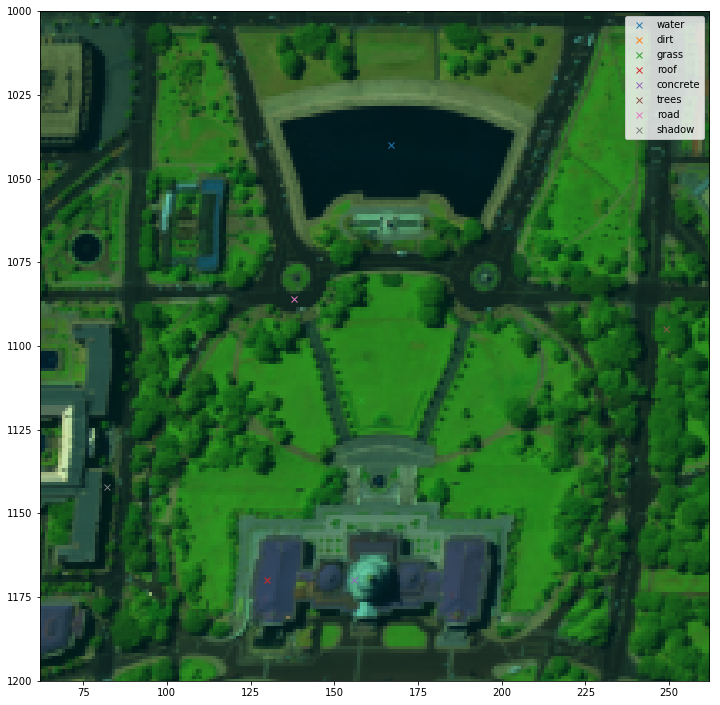

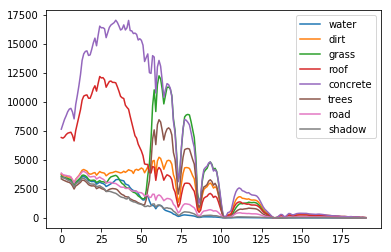

In [21]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])
points = dc.ref_points

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(12,48), show=False);

points = OrderedDict([
    ('water', (167, 1040)),
    ('dirt', (132, 272)),
    #('dirt', (205, 1023)),
    ('grass', (158, 1116)),
    #('grass', (166, 1105)),
    ('roof', (130, 1170)),
    ('concrete', (156, 1170)),
    #('trees', (249, 1123)),
    ('trees', (249, 1095)),
    #('road', (175, 1196)),
    ('road', (138, 1086)),
    #('shadow', (175, 465))
    ('shadow', (82, 1142))
])

spectra = OrderedDict()
for obj, pt in points.items():
    plt.plot(pt[0], pt[1],'x', label=obj)
    spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
plt.legend()
plt.xlim([62,262])
plt.ylim([1200,1000])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

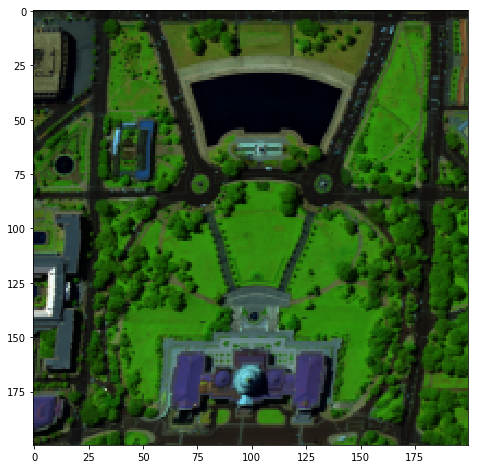

In [3]:
# only use a subset of the image
xmin = 62
xmax = 262
ymin = 1000
ymax = 1200
img_shape = (ymax-ymin, xmax-xmin)
subset = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
subset = subset.reshape(data.shape[0], img_shape[0]*img_shape[1])
dc.plot_color_img(subset, img_shape);

# The following example only includes sources that contribute at least 19%

In [4]:
import scipy.sparse
points = dc.ref_points
A0,S0 = dc.init_nmf(subset, img_shape, points, spectra)

def prox_max_entries(X, step, axis=0, max_entries=3):
    """Limit the number of features that can contribute to the spectrum in each pixel
    """
    sidx = np.argsort(X, axis=axis)
    X[sidx>max_entries-1] = 0
    return X

def prox_gentle_thresh(X, step, axis=0, thresh=.3, max_steps=1000):
    """Gently apply a threshold
    """
    X[X<thresh*step/max_steps] = 0
    return X

def prox_gentle_thresh_plus(X, step, axis=0, thresh=.3, max_steps=1000):
    """Gently apply a threshold
    """
    X = proxmin.operators.prox_plus(X, step)
    return prox_gentle_thresh(X, step, axis, thresh, max_steps)

def prox_gentle_thresh_plus(axis=0, thresh=.3, max_it=1000):
    it = 0
    def prox_gentle_thresh(X, step, axis=0, thresh=.3, max_it=1000):
        """Gently apply a threshold
        """
        X = proxmin.operators.prox_plus(X, step)
        nonlocal it
        if it>max_it:
            it = max_it
        else:
            it += 1
        X[:-1][X[:-1]<thresh*it/max_it] = 0
        return X
    return prox_gentle_thresh

#Ls = [[None], [np.ones((1,S0.shape[0])), scipy.sparse.identity(S0.shape[0])]]
Ls = [[None], [np.ones((1,S0.shape[0]))]]

prox_A = proxmin.operators.prox_plus
#prox_g = [[proxmin.operators.prox_id],[dc.prox_ones, prox_gentle_thresh]]
prox_g = [[proxmin.operators.prox_id],[dc.prox_ones]]
#steps_g = [[None],[None, None]]
prox_S = partial(prox_gentle_thresh_plus(), axis=0, thresh=.19, max_it=1000)

In [5]:
#A, S = nmf.nmf(subset, A0, S0, prox_A, max_iter=1000, Ls=Ls, proxs_g=prox_g, steps_g=steps_g)
A, S, hist = nmf.nmf(subset, A0, S0, prox_A, prox_S, max_iter=1000, Ls=Ls, proxs_g=prox_g, traceback=True)

functools.partial(<function prox_gentle_thresh_plus.<locals>.prox_gentle_thresh at 0x148463e18>, axis=0, thresh=0.19, max_it=1000)


INFO:proxmin.algorithms:Completed 1001 iterations


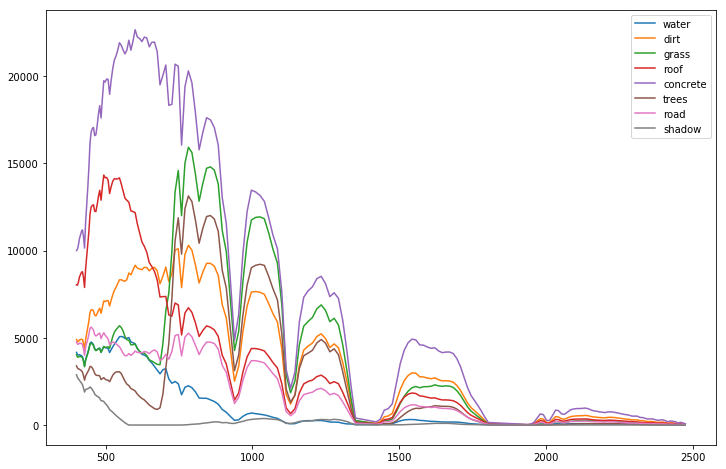

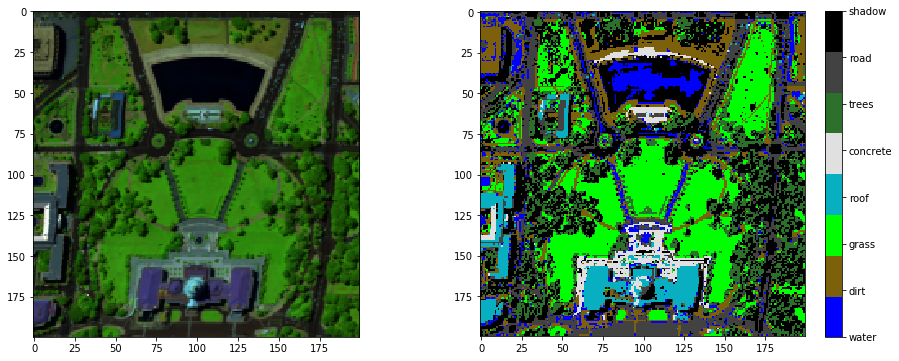

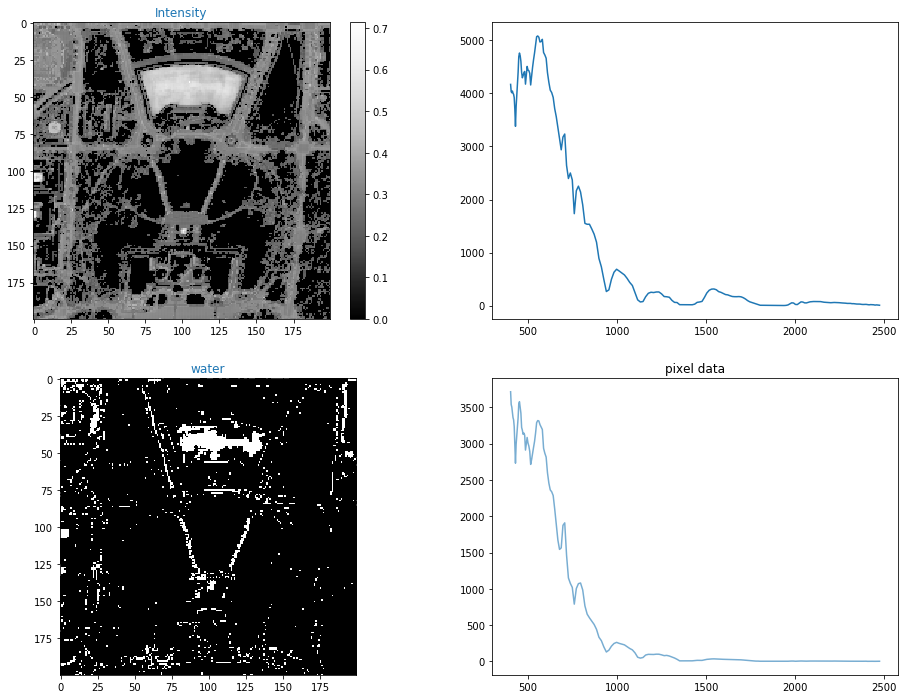

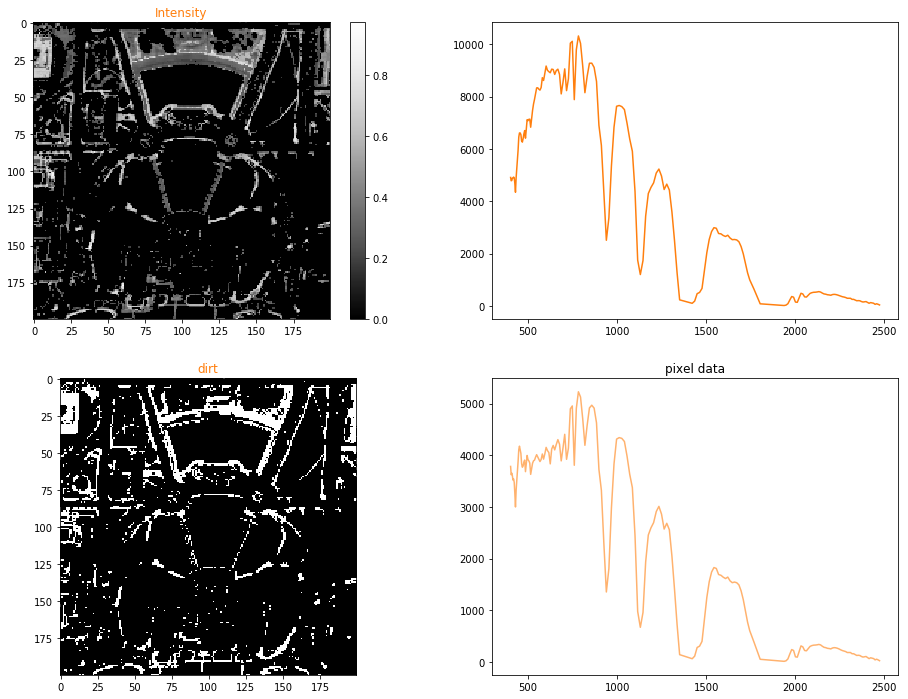

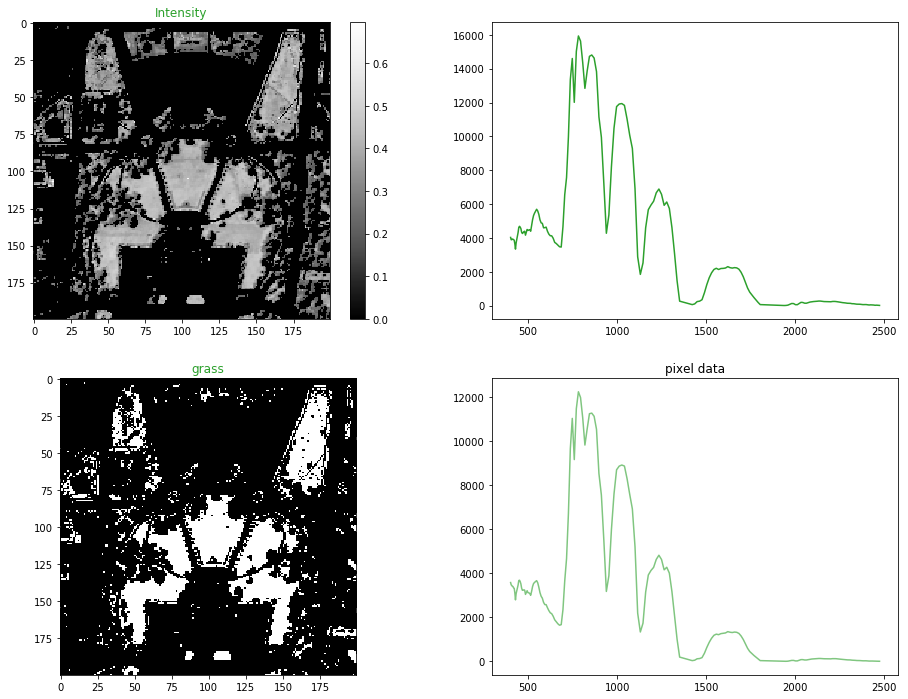

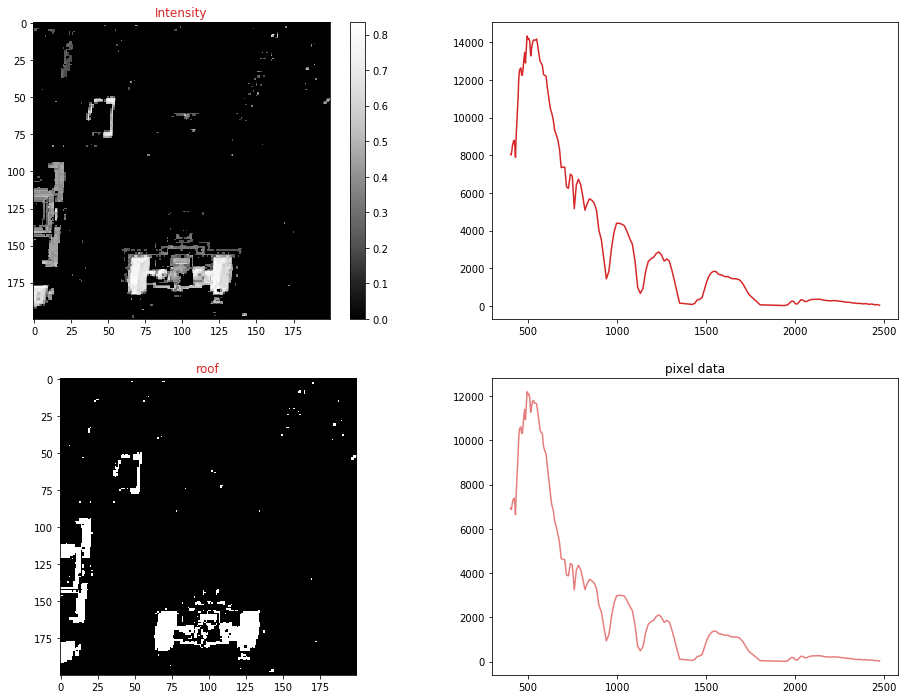

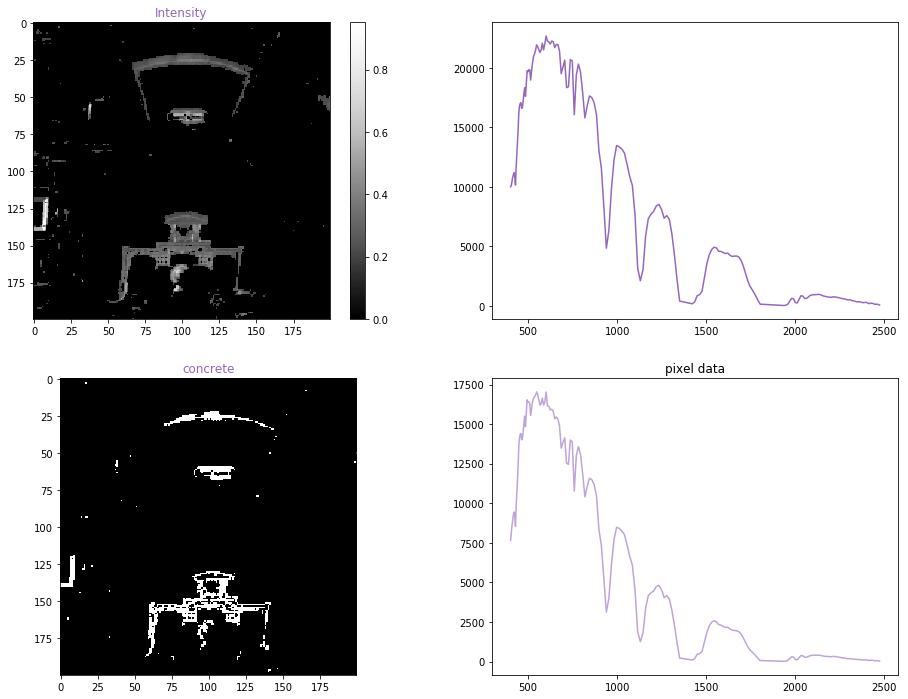

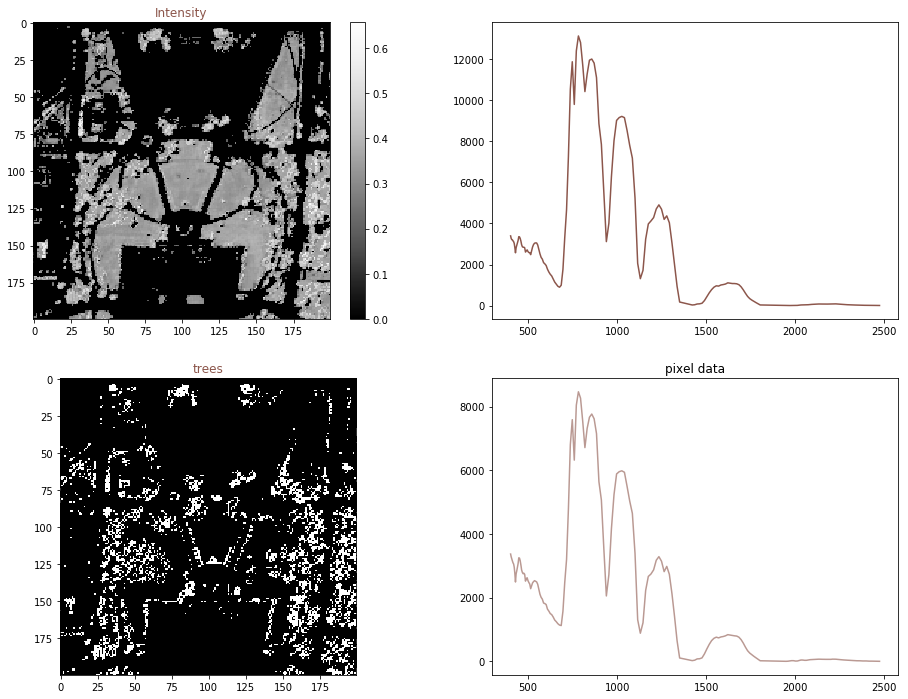

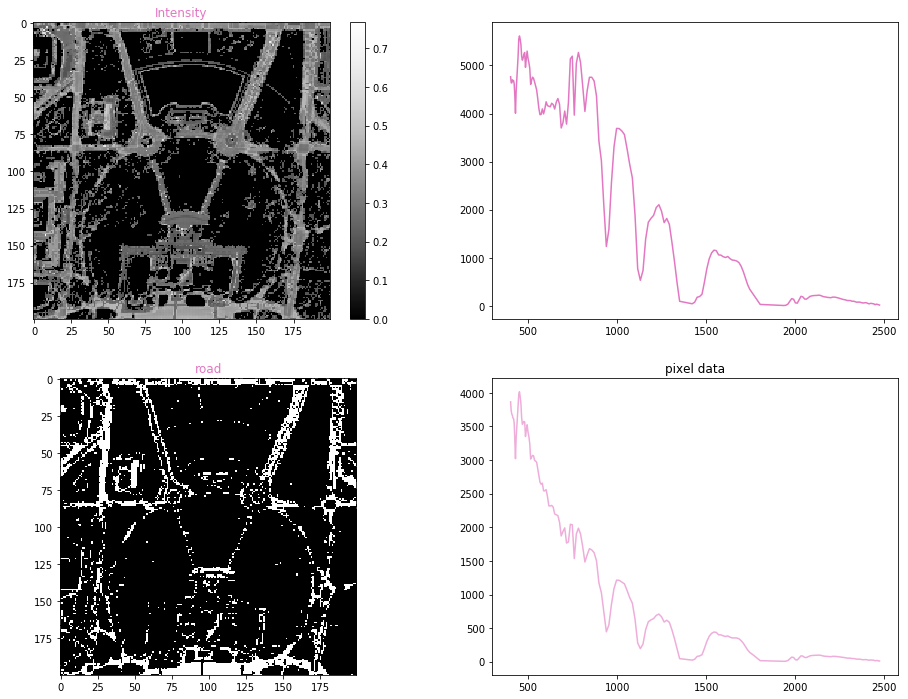

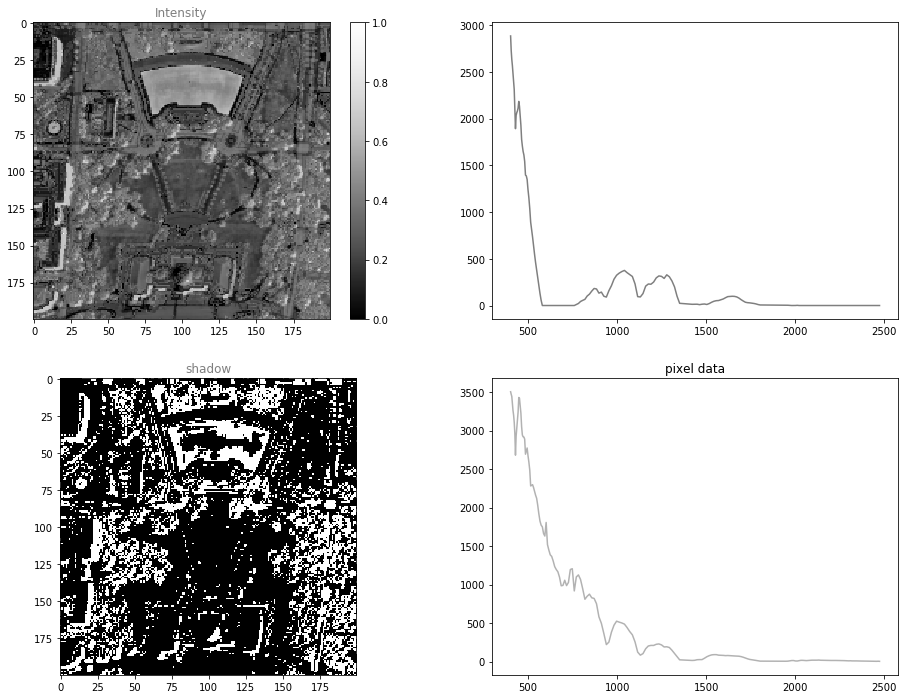

In [6]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(subset, img_shape, S, points, figsize=(16,6))
dc.plot_objects(subset, A, S, img_shape, points, spectra, wavelength=wavelength)

# The following example only includes features contributing at least 10%

In [26]:
import scipy.sparse
points = dc.ref_points
A0,S0 = dc.init_nmf(subset, img_shape, points, spectra)

def prox_max_entries(X, step, axis=0, max_entries=3):
    """Limit the number of features that can contribute to the spectrum in each pixel
    """
    sidx = np.argsort(X, axis=axis)
    X[sidx>max_entries-1] = 0
    return X

def prox_gentle_thresh(X, step, axis=0, thresh=.3, max_steps=1000):
    """Gently apply a threshold
    """
    X[X<thresh*step/max_steps] = 0
    return X

def prox_gentle_thresh_plus(X, step, axis=0, thresh=.3, max_steps=1000):
    """Gently apply a threshold
    """
    X = proxmin.operators.prox_plus(X, step)
    return prox_gentle_thresh(X, step, axis, thresh, max_steps)

def prox_gentle_thresh_plus(axis=0, thresh=.3, max_it=1000):
    it = 0
    def prox_gentle_thresh(X, step, axis=0, thresh=.3, max_it=1000):
        """Gently apply a threshold
        """
        X = proxmin.operators.prox_plus(X, step)
        nonlocal it
        if it>max_it:
            it = max_it
        else:
            it += 1
        X[:-1][X[:-1]<thresh*it/max_it] = 0
        return X
    return prox_gentle_thresh

#Ls = [[None], [np.ones((1,S0.shape[0])), scipy.sparse.identity(S0.shape[0])]]
Ls = [[None], [np.ones((1,S0.shape[0]))]]

prox_A = proxmin.operators.prox_plus
#prox_g = [[proxmin.operators.prox_id],[dc.prox_ones, prox_gentle_thresh]]
prox_g = [[proxmin.operators.prox_id],[dc.prox_ones]]
#steps_g = [[None],[None, None]]
prox_S = partial(prox_gentle_thresh_plus(), axis=0, thresh=.1, max_it=1000)

In [27]:
A, S, hist = nmf.nmf(subset, A0, S0, prox_A, prox_S, max_iter=1000, Ls=Ls, proxs_g=prox_g, traceback=True)

functools.partial(<function prox_gentle_thresh_plus.<locals>.prox_gentle_thresh at 0x14169fea0>, axis=0, thresh=0.1, max_it=1000)


INFO:proxmin.algorithms:Completed 1001 iterations


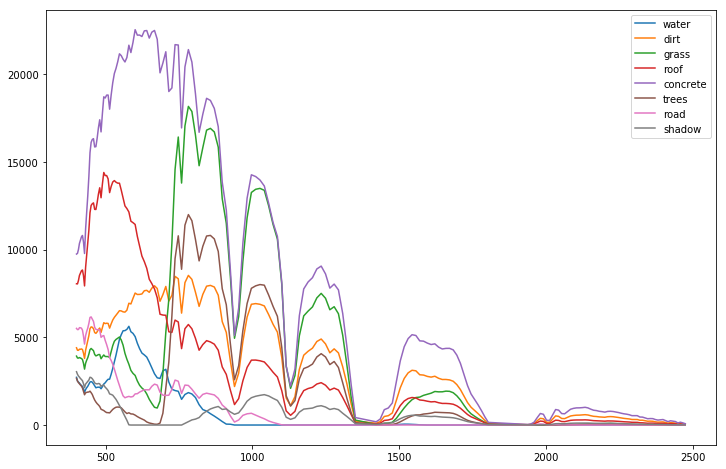

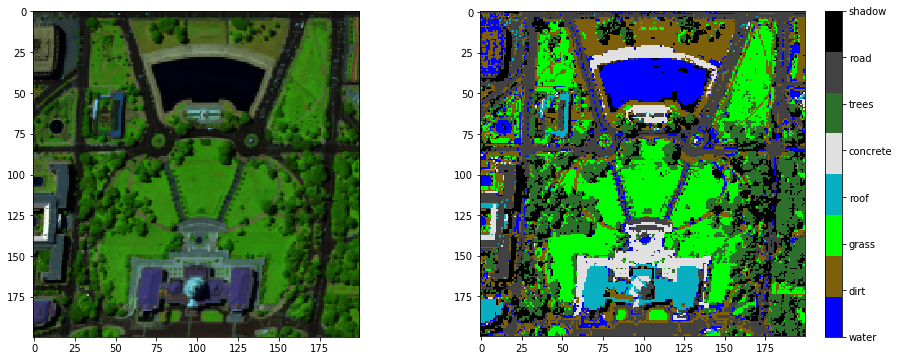

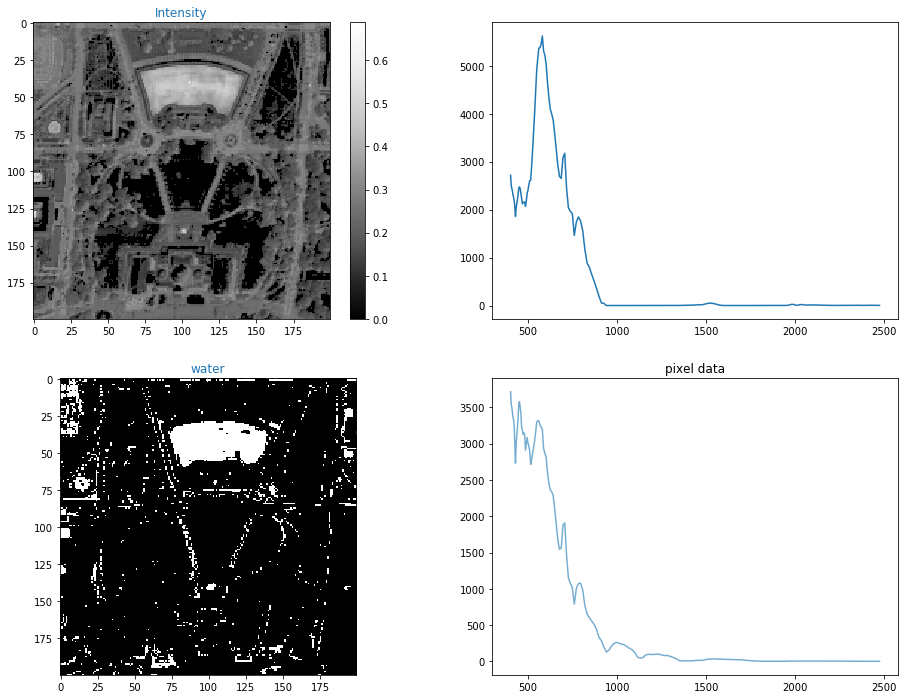

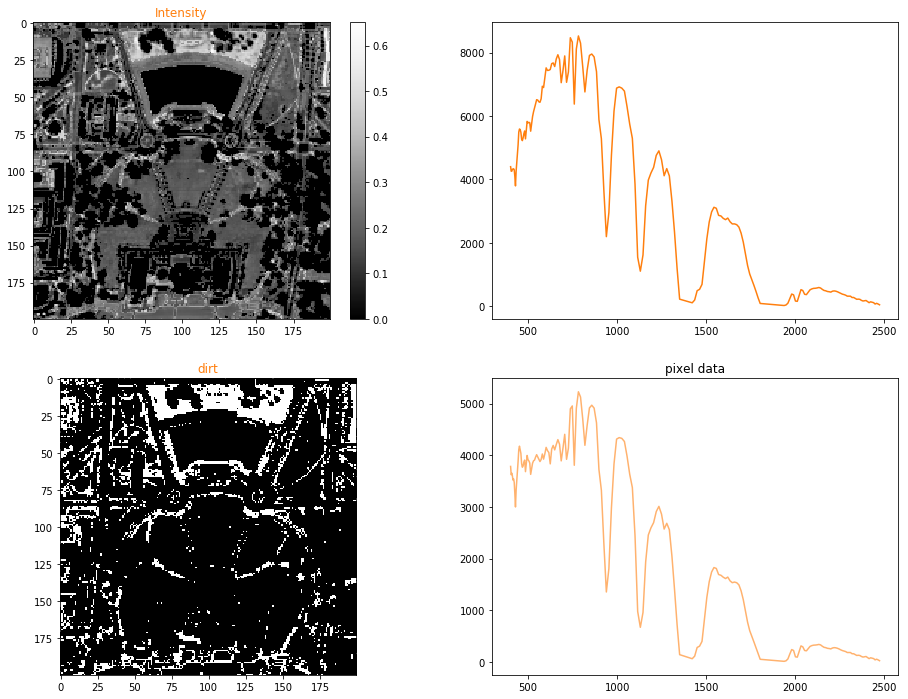

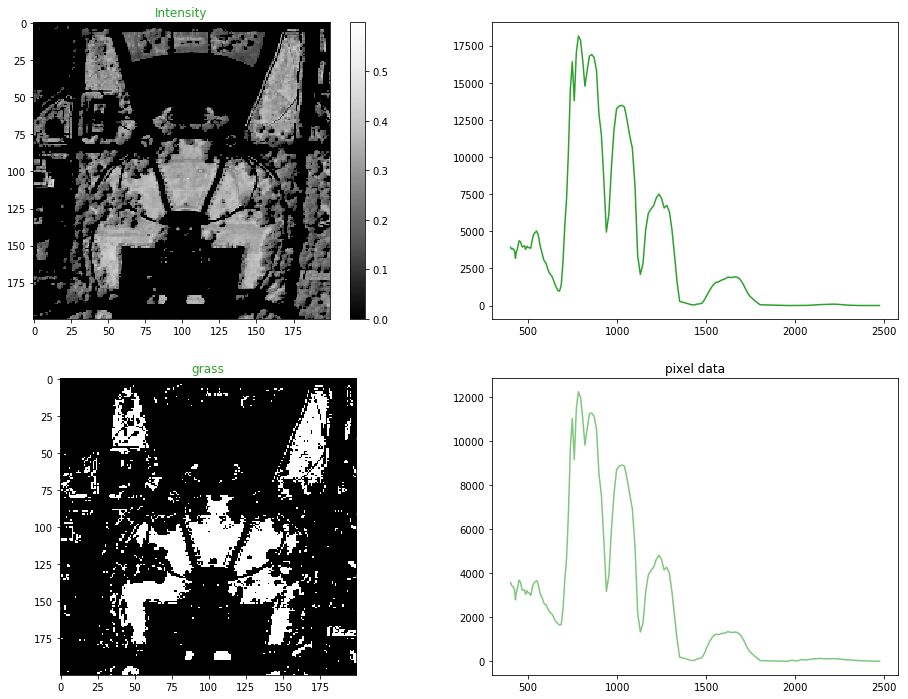

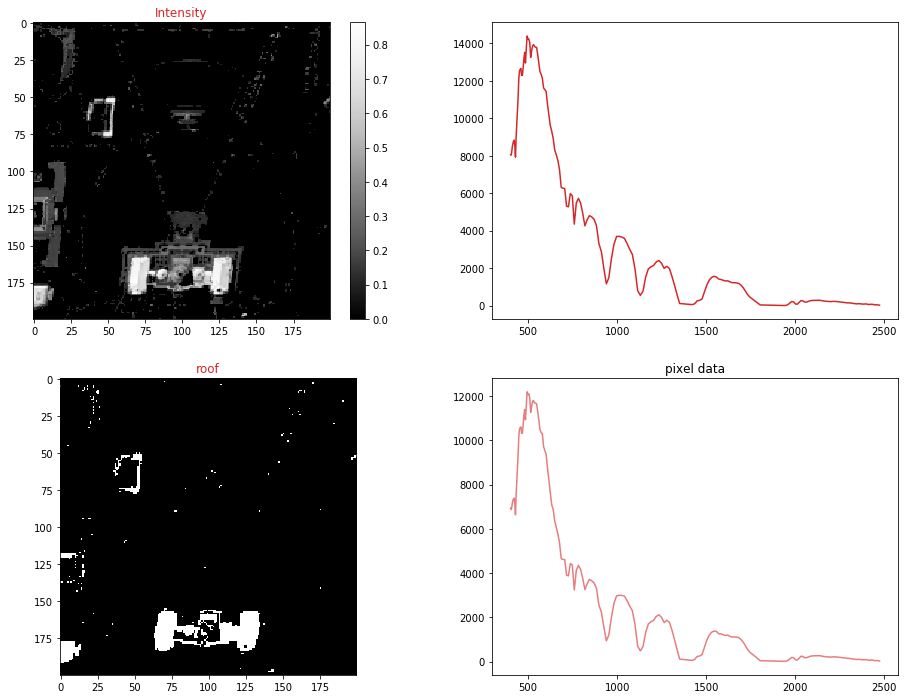

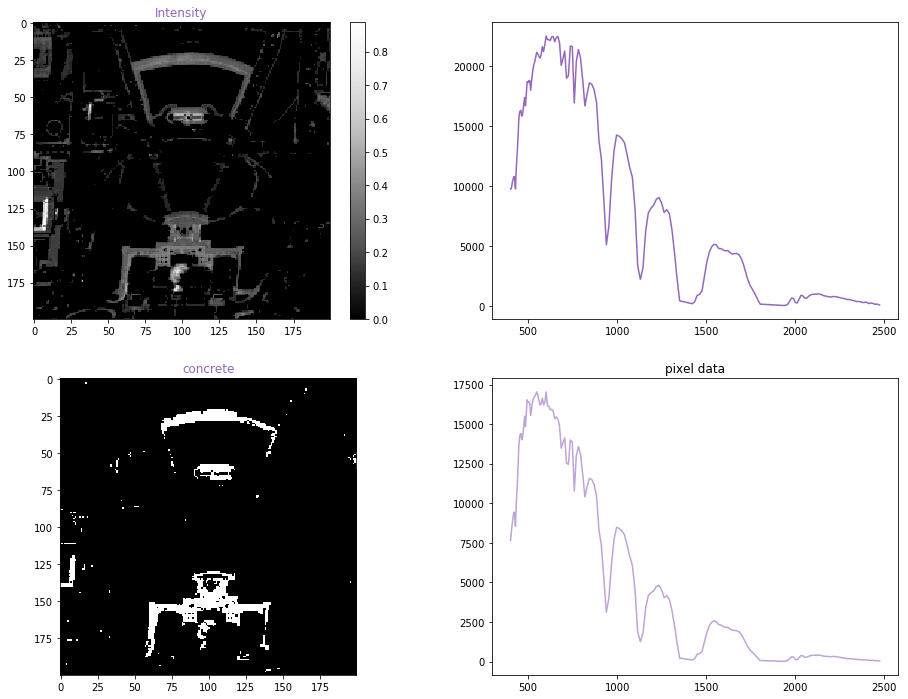

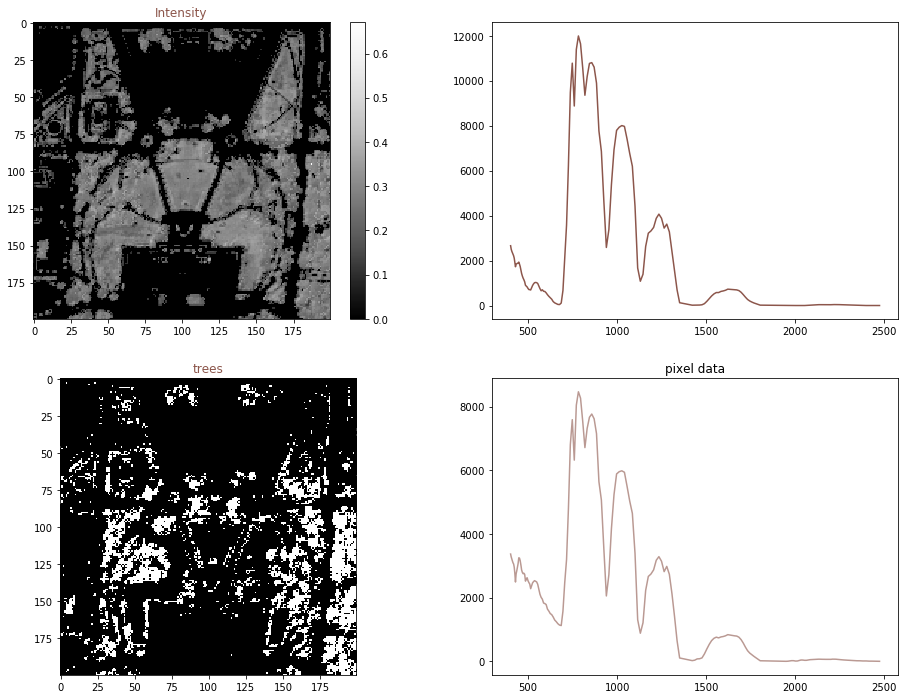

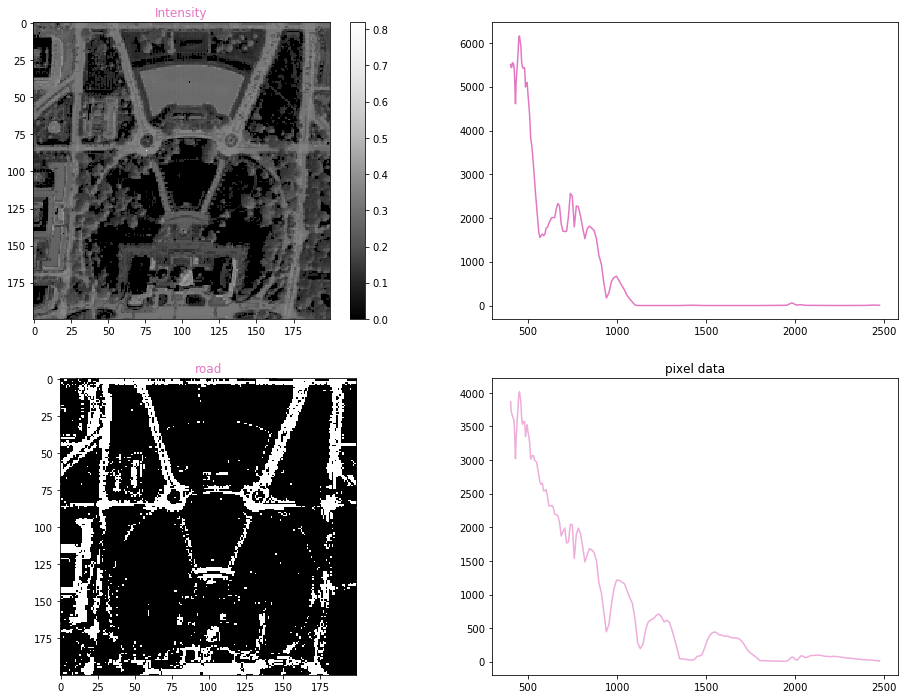

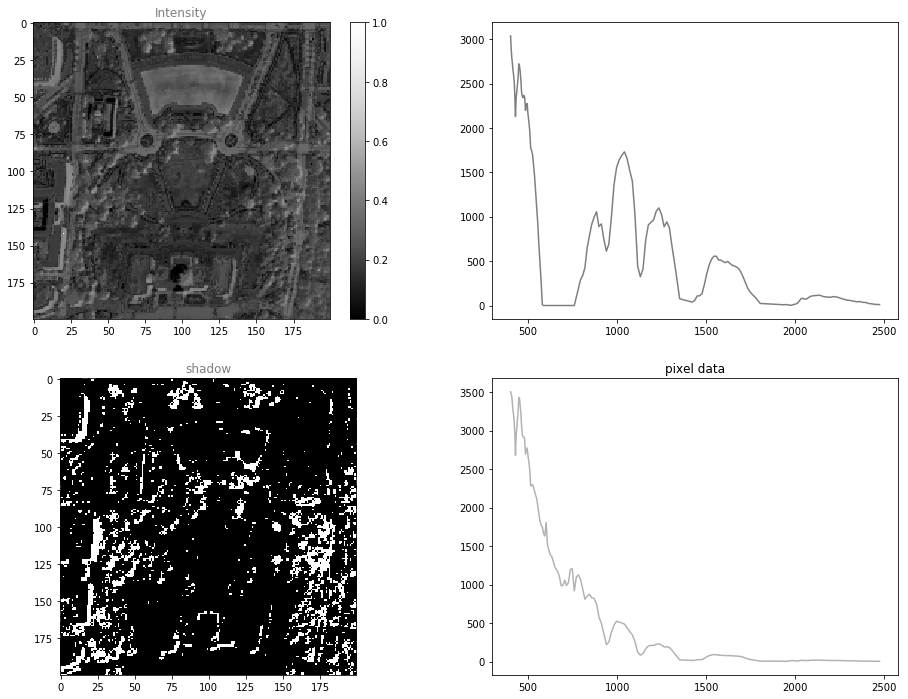

In [28]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(subset, img_shape, S, points, figsize=(16,6))
dc.plot_objects(subset, A, S, img_shape, points, spectra, wavelength=wavelength)